### **Make a new dataset**
- target seq
- binder seq
- motif seq
- cluster

In [1]:
from transformers import T5Tokenizer, T5EncoderModel
import torch
import re
!pip install sentencepiece
import sentencepiece
import torch
from torch import nn
from transformers import T5ForConditionalGeneration, T5Tokenizer
from torch.utils.data import DataLoader, Dataset

In [2]:
import os
os.chdir('/content/drive/MyDrive/Programmable Biology Group/Srikar/Code/proteins/flamingo-ppi-gen/data_dump/old_dat/')

In [3]:
import pandas as pd
import re

def preprocess_snp_data(file_path):
    # Read the dataset
    snp_df = pd.read_csv(file_path)

    # Function to transform energy scores
    def transform_energy_scores(energy_scores):
        transformed_scores = []
        for score in energy_scores:
            # Replace sequences of spaces/newlines with a comma
            score = re.sub(r'[\s\n]+', ',', score)
            # Remove a comma after an opening square bracket
            score = re.sub(r'\[\s*,', '[', score)
            # Remove leading commas/whitespace
            score = re.sub(r'^[\s,]+', '', score)
            transformed_scores.append(score)
        return transformed_scores

    # Apply transformations
    snp_df['energy_scores'] = transform_energy_scores(snp_df['energy_scores'])
    snp_df['energy_scores_lengths'] = snp_df['energy_scores'].apply(
        lambda x: x.count(',') + 1 - (1 if x.startswith(',') else 0)
    )

    # Calculate lengths for other columns
    snp_df['peptide_source_RCSB_lengths'] = snp_df['peptide_source_RCSB'].apply(len)
    snp_df['protein_RCSB_lengths'] = snp_df['protein_RCSB'].apply(len)
    snp_df['protein_derived_seq_length'] = snp_df['protein_derived_sequence'].apply(len)
    snp_df['peptide_derived_seq_length'] = snp_df['peptide_derived_sequence'].apply(len)

    # Calculate matching lengths count (optional, depending on your needs)
    snp_df['matching_lengths_count'] = (snp_df['energy_scores_lengths'] == snp_df['peptide_derived_seq_length']).sum()

    return snp_df

# Applying the preprocessing pipeline to each dataset
test_snp = preprocess_snp_data('testing_dataset.csv')
train_snp = preprocess_snp_data('training_dataset.csv')
val_snp = preprocess_snp_data('validation_dataset.csv')


In [4]:
unique_seqs = pd.concat([train_snp['peptide_derived_sequence'], train_snp['protein_derived_sequence'],
                         test_snp['peptide_derived_sequence'], test_snp['protein_derived_sequence'],
                         val_snp['peptide_derived_sequence'], val_snp['protein_derived_sequence']]).unique()

In [5]:
max_length = max(len(seq) for seq in unique_seqs)
print(max_length)

996


In [6]:
import torch
import re
import pickle
from torch.utils.data import Dataset
from torch.nn.functional import pad

class ProteinInteractionDataset(Dataset):
    def __init__(self, dataframe):
        # self.protT5_model = T5ForConditionalGeneration.from_pretrained("Rostlab/prot_t5_xl_bfd")
        # self.protT5_tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_bfd")
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        peptide_seq = self.dataframe.iloc[idx]['peptide_derived_sequence']
        protein_seq = self.dataframe.iloc[idx]['protein_derived_sequence']
        energy_scores = self.dataframe.iloc[idx]['energy_scores']

        max_length = 984

        # Process the energy_scores
        energy_scores = re.findall(r'-?\d+\.?\d*(?:e[-+]?\d+)?', energy_scores)
        energy_scores = [float(score) for score in energy_scores]
        energy_scores = one_hot_encode_energy_scores(energy_scores)
        # energy_scores_padded = pad(torch.tensor(energy_scores), (0, max_length - len(energy_scores)), "constant", 0)

        return torch.tensor(energy_scores), peptide_seq, protein_seq

def one_hot_encode_energy_scores(scores):
        # Assuming 'scores' is a list of energy score values
        return [1 if score <= -1 else 0 for score in scores]

In [7]:
# Create datasets with tokenizer
train_dataset = ProteinInteractionDataset(train_snp)
test_dataset = ProteinInteractionDataset(test_snp)
val_dataset = ProteinInteractionDataset(val_snp)


In [8]:
from torch.utils.data import DataLoader

train_batch_size = 1
test_batch_size = 1
val_batch_size = 1

# Create the DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=val_batch_size)


### **Background Functions**

General

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn.functional as F
# from transformers import RobertaModel  # Assuming use of Hugging Face's transformer models

# Helper Functions
def exists(val):
    return val is not None

def set_module_requires_grad_(module, requires_grad):
    for param in module.parameters():
        param.requires_grad = requires_grad

def freeze_model_and_make_eval_(model):
    model.eval()
    set_module_requires_grad_(model, False)

# LayerNorm class
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super().__init__()
        self.gain = nn.Parameter(torch.ones(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.gain * (x - mean) / (std + self.eps)

# Residual class
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

# SwiGLU activation function
class SwiGLU(nn.Module):
    def forward(self, x):
        return F.silu(x[..., :x.shape[-1] // 2]) * x[..., x.shape[-1] // 2:]


class LayerNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        return self.norm(x)

class SwiGLU(nn.Module):
    def forward(self, x):
        x, gate = x.chunk(2, dim=-1)
        return F.silu(gate) * x



Main Perciever+Cross Attn

In [ ]:
!pip install einops
!pip install einops-exts

In [ ]:
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:4096'

import torch
from torch import nn, einsum
import torch.nn.functional as F

from einops import rearrange, repeat
from einops_exts import rearrange_many, repeat_many

def exists(val):
    return val is not None

def FeedForward(dim, mult = 4):
    inner_dim = int(dim * mult)
    return nn.Sequential(
        nn.LayerNorm(dim),
        nn.Linear(dim, inner_dim, bias = False),
        nn.GELU(),
        nn.Linear(inner_dim, dim, bias = False)
    )

class PerceiverAttention(nn.Module):
    def __init__(self, *, dim, concatenated_dim, dim_head=64, heads=8):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        inner_dim = dim_head * heads

        self.norm_media = nn.LayerNorm(dim)
        self.norm_latents = nn.LayerNorm(dim)
        self.to_q = nn.Linear(dim, inner_dim, bias=False)
        self.to_kv = nn.Linear(dim, inner_dim * 2, bias=False)
        self.to_out = nn.Linear(inner_dim, dim, bias=False)


    def forward(self, x, latents):
        x = self.norm_media(x)
        latents = self.norm_latents(latents)

        # print('x shape perciever attn:', x.shape)
        # print('latents shape perceiver attn', latents.shape)

        q = self.to_q(latents)
        # print('q shape:',q.shape)

        q = rearrange(q, 'b n (h d) -> b h n d', h=self.heads)
        q = q * self.scale


        kv_input = torch.cat((x, latents), dim=1)
        k, v = self.to_kv(kv_input).chunk(2, dim=-1)

        # print('k shape:',k.shape)
        # print('v shape:',v.shape)
        k = rearrange(k, 'b n (h d) -> b h n d', h=self.heads)
        v = rearrange(v, 'b n (h d) -> b h n d', h=self.heads)

        # print('rearrangement in perceiver cross attn complete...')
        # print('q shape:',q.shape)
        # print('k shape:',k.shape)
        # print('v shape:',v.shape)

        sim = einsum('... i d, ... j d -> ... i j', q, k)
        attn = sim.softmax(dim=-1)
        out = einsum('... i j, ... j d -> ... i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')

        return self.to_out(out)

class PerceiverResampler(nn.Module):
    def __init__(self, *, dim, depth, dim_head=64, heads=8, num_latents=64, concatenated_dim=1536):
        super().__init__()
        self.latents = nn.Parameter(torch.randn(num_latents, dim))
        self.layers = nn.ModuleList([])

        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PerceiverAttention(dim=dim, concatenated_dim=concatenated_dim, dim_head=dim_head, heads=heads),
                FeedForward(dim=dim)
            ]))

    def forward(self, x):
        latents = repeat(self.latents, 'n d -> b n d', b=x.shape[0])

        for attn, ff in self.layers:
            latents = attn(x, latents) + latents
            latents = ff(latents) + latents

        return latents

class MaskedCrossAttention(nn.Module):
    def __init__(self, *, dim, concatenated_dim=1536, dim_head=64, heads=8, only_attend_immediate_media=True):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        inner_dim = dim_head * heads

        self.norm = nn.LayerNorm(dim)
        self.to_q = nn.Linear(dim, inner_dim, bias=False)
        self.to_kv = nn.Linear(dim, inner_dim * 2, bias=False)
        self.to_out = nn.Linear(inner_dim, dim, bias=False)
        self.only_attend_immediate_media = only_attend_immediate_media

    def forward(self, x, media, media_locations=None):
        b, t, _ = x.shape
        _, m, _ = media.shape
        h = self.heads

        x = self.norm(x)
        q = self.to_q(x)
        q = rearrange(q, 'b n (h d) -> b h n d', h=h)

        # No need to reshape media as it's already 3D
        k, v = self.to_kv(media).chunk(2, dim=-1)
        k = rearrange(k, 'b n (h d) -> b h n d', h=h)
        v = rearrange(v, 'b n (h d) -> b h n d', h=h)

        q = q * self.scale
        sim = einsum('... i d, ... j d -> ... i j', q, k)

        if media_locations is not None:
            mask = media_locations.unsqueeze(1).unsqueeze(2)
            mask = rearrange(mask, 'b n -> b 1 n 1')
            sim = sim.masked_fill(mask == 0, float('-inf'))

        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)
        out = einsum('... i j, ... j d -> ... i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)', h=self.heads)

        return self.to_out(out)


class GatedCrossAttentionBlock(nn.Module):
    def __init__(self, *, dim, dim_head=64, heads=8, ff_mult=4, only_attend_immediate_media=True):
        super().__init__()
        self.attn = MaskedCrossAttention(dim=dim, concatenated_dim=1536, dim_head=dim_head, heads=heads, only_attend_immediate_media=only_attend_immediate_media)
        self.attn_gate = nn.Parameter(torch.tensor([0.]))
        self.ff = FeedForward(dim, mult=ff_mult)
        self.ff_gate = nn.Parameter(torch.tensor([0.]))

    def forward(self, x, media, media_locations=None):
        gate = self.attn_gate.tanh()
        x = self.attn(x, media, media_locations=media_locations) * gate + x
        x = self.ff(x) * self.ff_gate.tanh() + x
        return x



### **ProtFlamingo**

In [ ]:
from transformers import GPT2Tokenizer

# Load the tokenizer for the ProtGPT2 model from Hugging Face
tokenizer = GPT2Tokenizer.from_pretrained('nferruz/ProtGPT2')

# Get the number of tokens in the tokenizer
num_tokens = len(tokenizer)

print(f"The ProtGPT2 model has {num_tokens} tokens in its vocabulary.")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


The ProtGPT2 model has 50257 tokens in its vocabulary.


In [ ]:
import torch
import torch.nn as nn
from transformers import GPT2LMHeadModel, GPT2Tokenizer

class ProtFlamingo(nn.Module):
    def __init__(self, model_path, cross_attn_every=1, dim_head=64, heads=8, motif_embedding_dim=1280, perceiver_depth=2, perceiver_num_latents=64):
        super().__init__()

        # Load ProtGPT2 model
        self.protGPT2_model = GPT2LMHeadModel.from_pretrained(model_path)
        self.protGPT2_tokenizer = GPT2Tokenizer.from_pretrained(model_path)

        # Create an embedding layer for one-hot motifs to learn positional embeddings
        self.motif_embedding = nn.Embedding(num_embeddings=motif_embedding_dim, embedding_dim=self.protGPT2_model.config.n_embd)

        # Define Perceiver Resampler
        self.perceiver_resampler = PerceiverResampler(dim=self.protGPT2_model.config.n_embd, depth=perceiver_depth, dim_head=dim_head, heads=heads, num_latents=perceiver_num_latents)

        # Access the decoder blocks from ProtGPT2 model
        self.decoder_blocks = self.protGPT2_model.transformer.h

        # Intersperse GatedCrossAttentionBlocks within the GPT2 decoder blocks
        self.layers = nn.ModuleList([])
        for i, block in enumerate(self.decoder_blocks):
            self.layers.append(block)
            if i % cross_attn_every == 0 and i != 0:
                self.layers.append(GatedCrossAttentionBlock(dim=self.protGPT2_model.config.n_embd, dim_head=dim_head, heads=heads))

    def forward(self, target_seqs, one_hot_motifs):
        # Tokenize target sequences
        inputs = self.protGPT2_tokenizer(target_seqs, return_tensors="pt")
        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)

        # Obtain embeddings from GPT2
        embeddings = self.protGPT2_model.transformer.wte(input_ids)
        # print('embeddings shape')
        # print(embeddings.shape)

        # Convert one-hot motifs to learned positional embeddings
        one_hot_motif_embeddings = self.motif_embedding(one_hot_motifs)
        # print('one hot motif shape')
        # print(one_hot_motif_embeddings.shape)

        # Process through Perceiver Resampler
        processed_motif_embeddings = self.perceiver_resampler(one_hot_motif_embeddings)
        # print(processed_motif_embeddings.shape)

        # Pass through layers (GPT2 Blocks and GatedCrossAttentionBlocks)
        for layer in self.layers:
            # print(layer)
            if isinstance(layer, GatedCrossAttentionBlock):
                embeddings = layer(embeddings, processed_motif_embeddings)
            else:
                layer_outputs = layer(embeddings, attention_mask=attention_mask)
                embeddings = layer_outputs[0]

        # Final logits

        logits = self.protGPT2_model.lm_head(embeddings)
        # print(logits)
        # print(logits.shape)
        #print(self.protGPT2_model)
        return logits



### **Initialize Model**

In [ ]:
# Parameters for initializing the model
cross_attn_every = 1  # Intersperse a GatedCrossAttentionBlock after every 3 GPT2 blocks
dim_head = 64         # Dimension of each head in multi-head attention
heads = 8             # Number of heads in multi-head attention
perceiver_num_latents = 64  # Number of latents in PerceiverResampler
perceiver_depth = 2        # Depth of the PerceiverResampler

# Initialize the ProtFlamingo model
model = ProtFlamingo(model_path='nferruz/ProtGPT2',
                             cross_attn_every=cross_attn_every,
                             dim_head=dim_head,
                             heads=heads,
                             perceiver_num_latents=perceiver_num_latents,
                             perceiver_depth=perceiver_depth)

# If using a GPU, move the model to GPU
if torch.cuda.is_available():
    model = model.cuda()

import torch

def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)

model.apply(init_weights)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [ ]:
tokenizer

GPT2Tokenizer(name_or_path='nferruz/ProtGPT2', vocab_size=50257, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}

### **Wandb Loop**

In [ ]:
# wandb training

In [ ]:
!pip install wandb

In [ ]:
import torch
import torch.nn as nn
import wandb
import matplotlib.pyplot as plt

# Train epoch function
def train_epoch(model, data_loader, optimizer, scheduler, device, epoch, clip_value=1.0):
    model.train()
    total_loss = 0
    total_batches = 0

    for batch in data_loader:
        one_hot_motifs, target_seqs_tuple, binder_seqs_tuple = batch
        target_seqs = target_seqs_tuple[0]
        binder_seqs = binder_seqs_tuple[0]

        # Assuming tokenizer is predefined
        binder_inputs = tokenizer(target_seqs, return_tensors="pt")
        binder_input_ids = binder_inputs['input_ids'].to(device)
        binder_attention_mask = binder_inputs['attention_mask'].to(device)

        one_hot_motifs = one_hot_motifs.to(device)

        optimizer.zero_grad()
        outputs = model(target_seqs, one_hot_motifs)
        loss = nn.CrossEntropyLoss()(outputs.view(-1, outputs.size(-1)), binder_input_ids.view(-1))

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        optimizer.step()

        total_loss += loss.item()
        total_batches += 1
        wandb.log({"train_batch_loss": loss.item()})  # Logging for each batch

    scheduler.step()  # Update the learning rate
    average_loss = total_loss / total_batches
    print(f'Training Loss: {average_loss}')
    wandb.log({"epoch": epoch, "train_loss": average_loss})  # Logging for each epoch
    return average_loss

# Validation and Test function
def validate_or_test_model(model, data_loader, device, epoch, is_validation=True):
    model.eval()
    total_loss = 0
    total_batches = 0

    with torch.no_grad():
        for batch in data_loader:
            one_hot_motifs, target_seqs_tuple, binder_seqs_tuple = batch
            target_seqs = target_seqs_tuple[0]
            binder_seqs = binder_seqs_tuple[0]

            binder_inputs = tokenizer(target_seqs, return_tensors="pt")
            binder_input_ids = binder_inputs['input_ids'].to(device)
            one_hot_motifs = one_hot_motifs.to(device)

            outputs = model(target_seqs, one_hot_motifs)
            loss = nn.CrossEntropyLoss()(outputs.view(-1, outputs.size(-1)), binder_input_ids.view(-1))
            total_loss += loss.item()
            total_batches += 1

    average_loss = total_loss / total_batches
    print(f"{'Validation' if is_validation else 'Testing'} Loss: {average_loss:.4f}")

    phase = "val" if is_validation else "test"
    wandb.log({f"{phase}_loss": average_loss, "epoch": epoch})  # Logging for each epoch
    return average_loss

# Run training and evaluation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Modify the train_and_evaluate function to include scheduler
def train_and_evaluate(model, train_dataloader, val_dataloader, test_dataloader, optimizer, scheduler, num_epochs, device):
    train_losses, val_losses, test_losses = [], [], []

    for epoch in range(num_epochs):
        train_loss = train_epoch(model, train_dataloader, optimizer, scheduler, device, epoch)
        train_losses.append(train_loss)

        val_loss = validate_or_test_model(model, val_dataloader, device, epoch, is_validation=True)
        val_losses.append(val_loss)

        test_loss = validate_or_test_model(model, test_dataloader, device, epoch, is_validation=False)
        test_losses.append(test_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Testing Loss: {test_loss:.4f}")

    return train_losses, val_losses, test_losses

# Plotting function
def plot_losses(train_losses, val_losses, test_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title('Training, Validation, and Test Losses Per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    wandb.log({"loss_plot": wandb.Image(plt)})  # Logging the plot
    plt.show()



Weight Decay 1e-06
Learning Rates 0.0001


wandb: Currently logged in as: vskavi2003. Use `wandb login --relogin` to force relogin


Training Loss: 0.5638937865546132
Validation Loss: 0.5064
Testing Loss: 0.4447
Epoch 1/3, Training Loss: 0.5639, Validation Loss: 0.5064, Testing Loss: 0.4447
Training Loss: 0.12790367989617218
Validation Loss: 0.4477
Testing Loss: 0.4311
Epoch 2/3, Training Loss: 0.1279, Validation Loss: 0.4477, Testing Loss: 0.4311
Training Loss: 0.12388583613401342
Validation Loss: 0.5001
Testing Loss: 0.4475
Epoch 3/3, Training Loss: 0.1239, Validation Loss: 0.5001, Testing Loss: 0.4475


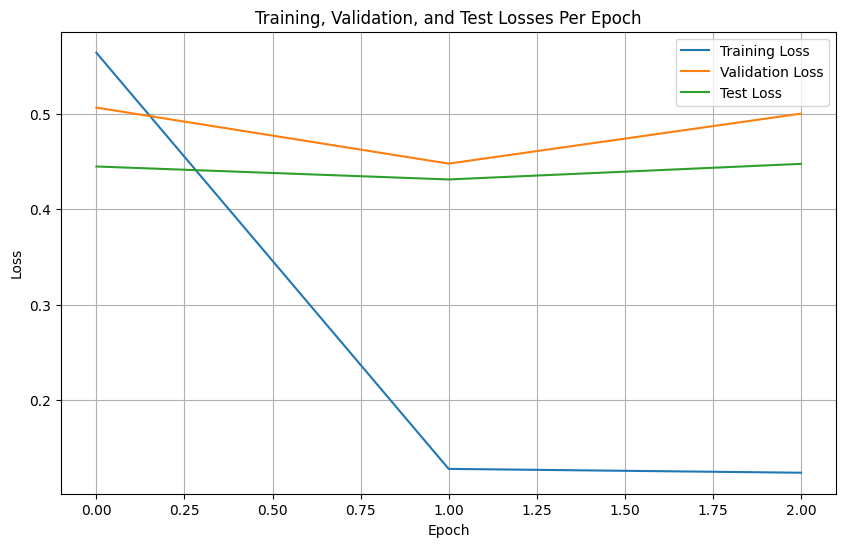

epoch,▁▁▁▅▅▅███
test_loss,▇▁█
train_batch_loss,█▃▂▁▂▂▁▂▂▁▂▁▂▁▂▁▁▁▁▁▁▂▁▁▂▁▁▁▁▂▁▄▁▁▁▂▁▁▁▂
train_loss,█▁▁
val_loss,█▁▇
epoch,2
test_loss,0.44746
train_batch_loss,0.0
train_loss,0.12389
val_loss,0.50007


In [ ]:
import torch
import torch.nn as nn
import wandb
import matplotlib.pyplot as plt
from torch.utils.data import Subset, DataLoader
import numpy as np

# Hyperparameter space
learning_rates = [0.0001]
weight_decays = [1e-6]

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for lr in learning_rates:
    for wd in weight_decays:

        print('Weight Decay',wd)
        print('Learning Rates', lr)

        # Initialize wandb with hyperparameters
        wandb.init(project="flamingo-protGPT2-srikar", entity="vskavi2003", reinit=True)

        # Set hyperparameters in wandb
        wandb.config.update({"learning_rate": lr, "weight_decay": wd, "epochs": 3, "batch_size": 1})

        # # Create subsets (assuming the dataset variables are already defined)
        # train_indices = np.random.choice(len(train_dataset), 2000, replace=False)
        # val_indices = np.random.choice(len(val_dataset), 500, replace=False)
        # test_indices = np.random.choice(len(test_dataset), 500, replace=False)

        # train_subset = Subset(train_dataset, train_indices)
        # val_subset = Subset(val_dataset, val_indices)
        # test_subset = Subset(test_dataset, test_indices)

        # train_dataloader = DataLoader(train_subset, batch_size=wandb.config.batch_size, shuffle=True)
        # val_dataloader = DataLoader(val_subset, batch_size=wandb.config.batch_size, shuffle=False)
        # test_dataloader = DataLoader(test_subset, batch_size=wandb.config.batch_size, shuffle=False)

        # Initialize model, optimizer, and scheduler for this configuration
        model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

        # Run training and evaluation for the current set of hyperparameters
        train_losses, val_losses, test_losses = train_and_evaluate(
            model, train_dataloader, val_dataloader, test_dataloader, optimizer, scheduler, wandb.config.epochs, device
        )

        plot_losses(train_losses, val_losses, test_losses)

        # Close the wandb run for this configuration
        wandb.finish()


### **Generate and Evaluate**

In [ ]:
!pip install Levenshtein

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 66.5 MB/s eta 0:00:00


In [ ]:
# import torch
# from tqdm import tqdm
# import Levenshtein as lev

# def generate_and_compare(model, dataloader, device):
#     model.to(device).eval()  # Ensure the model is in evaluation mode and on the right device

#     total_similarity_score = 0  # To accumulate similarity scores
#     total_sequences = 0  # To count the total number of sequences processed

#     for batch in tqdm(dataloader, desc="Processing"):
#         one_hot_motifs, target_seqs_tuple, binder_seqs_tuple = batch
#         binder_seqs = binder_seqs_tuple  # Assuming these are the sequences you want to compare against
#         target_seqs = target_seqs_tuple
#         one_hot_motifs = one_hot_motifs.to(device)

#         # Generate logits with the model
#         with torch.no_grad():
#             logits = model(target_seqs, one_hot_motifs)

#         # Convert logits to token ids
#         predictions = torch.argmax(logits, dim=-1)

#         # Decode generated ids to sequences
#         generated_seqs = [model.protGPT2_tokenizer.decode(ids, skip_special_tokens=True) for ids in predictions]

#         # Iterate through the batch to compare original and generated sequences
#         for original_seq, generated_seq in zip(binder_seqs, generated_seqs):
#             #print(f"Original Sequence: {original_seq}")
#             #print(f"Generated Sequence: {generated_seq}")
#             #print("-" * 50)
#             similarity_score = lev.ratio(original_seq, generated_seq)
#             #print(f"Similarity Score: {similarity_score}")
#             total_similarity_score += similarity_score
#             total_sequences += 1

#     average_similarity_score = total_similarity_score / total_sequences if total_sequences else 0
#     print(f"Average Similarity Score: {average_similarity_score:.4f}")



In [ ]:

# ## Usage

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# print("Validation Data")
# generate_and_compare(model, val_dataloader, device)

# print("\nTest Data")
# generate_and_compare(model, test_dataloader, device)


In [ ]:
def save_model(model, optimizer, scheduler, train_losses, val_losses, test_losses, model_path):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),  # Saving the scheduler state
        'train_losses': train_losses,
        'val_losses': val_losses,
        'test_losses': test_losses
    }, model_path)

# Define the path where you want to save your model
model_save_path = './model_WD_1e-6_LR_1e-4.pth'

# Call save_model function after training and evaluation
save_model(model, optimizer, scheduler, train_losses, val_losses, test_losses, model_save_path)


In [ ]:
import pandas as pd
from tqdm import tqdm
import torch
import Levenshtein as lev

def generate_and_compare_and_save_as_csv(model, dataloader, device, csv_path):
    model.to(device).eval()  # Ensure the model is in evaluation mode and on the right device

    # Prepare lists to accumulate sequences and scores
    original_seqs = []
    generated_seqs = []
    similarity_scores = []

    for batch in tqdm(dataloader, desc="Processing"):
        one_hot_motifs, target_seqs_tuple, binder_seqs_tuple = batch
        binder_seqs = binder_seqs_tuple  # Assuming these are the sequences you want to compare against
        target_seqs = target_seqs_tuple
        one_hot_motifs = one_hot_motifs.to(device)

        # Generate logits with the model
        with torch.no_grad():
            logits = model(target_seqs, one_hot_motifs)

        # Convert logits to token ids
        predictions = torch.argmax(logits, dim=-1)

        # Decode generated ids to sequences
        decoded_generated_seqs = [model.protGPT2_tokenizer.decode(ids, skip_special_tokens=True) for ids in predictions]

        # Iterate through the batch to compare original and generated sequences
        for original_seq, generated_seq in zip(binder_seqs, decoded_generated_seqs):
            similarity_score = lev.ratio(original_seq, generated_seq)
            original_seqs.append(original_seq)
            generated_seqs.append(generated_seq)
            similarity_scores.append(similarity_score)

    # Create a DataFrame
    df = pd.DataFrame({
        'Original Sequence': original_seqs,
        'Generated Sequence': generated_seqs,
        'Similarity Score': similarity_scores
    })

    # Save to CSV
    df.to_csv(csv_path, index=False)
    print(f"Saved sequences and similarity scores to {csv_path}")


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
csv_path_val = 'sequences_similarity_scores_val_model_WD_1e-6_LR_1e-4.csv'
generate_and_compare_and_save_as_csv(model, val_dataloader, device, csv_path_val)

csv_path_test = 'sequences_similarity_scores_test_model_WD_1e-6_LR_1e-4.csv'
generate_and_compare_and_save_as_csv(model, test_dataloader, device, csv_path_test)


Processing: 100%|██████████| 5818/5818 [06:37<00:00, 14.64it/s]


Saved sequences and similarity scores to sequences_similarity_scores_val_model_WD_1e-6_LR_1e-4.csv


Processing: 100%|██████████| 6879/6879 [07:48<00:00, 14.68it/s]

Saved sequences and similarity scores to sequences_similarity_scores_test_model_WD_1e-6_LR_1e-4.csv


In [ ]:
df_val = pd.read_csv(csv_path_val)
df_test = pd.read_csv(csv_path_test)

# Add columns for the lengths of original and generated sequences
df_val['Original Seq Length'] = df_val['Original Sequence'].str.len()
df_val['Generated Seq Length'] = df_val['Generated Sequence'].str.len()

df_test['Original Seq Length'] = df_test['Original Sequence'].str.len()
df_test['Generated Seq Length'] = df_test['Generated Sequence'].str.len()

# Save the updated DataFrames back to CSV
df_val.to_csv(csv_path_val, index=False)
df_test.to_csv(csv_path_test, index=False)

In [ ]:
# Calculate the similar length count for df_val and df_test
similar_length_count_val = sum(abs(df_val['Original Seq Length'] - df_val['Generated Seq Length']) <= 10)
similar_length_count_test = sum(abs(df_test['Original Seq Length'] - df_test['Generated Seq Length']) <= 10)

similar_length_count_val, similar_length_count_test

(3365, 3983)

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import pandas as pd
from tqdm import tqdm

def process_dataloader(dataloader, desc):
    # Dictionary to hold the mapping from binder_seqs to target_seqs
    binder_to_target_map = {}
    #print(binder_to_target_map)

    # Processing loop
    for batch in tqdm(dataloader, desc=desc):
        one_hot_motifs, target_seqs_tuple, binder_seqs_tuple = batch
        target_seqs = target_seqs_tuple# [seq[0] for seq in target_seqs_tuple]  # Adjust based on your data structure
        binder_seqs = binder_seqs_tuple# [seq[0] for seq in binder_seqs_tuple]  # Adjust based on your data structure

        # Update the mapping dictionary
        for binder_seq, target_seq in zip(binder_seqs, target_seqs):
            binder_to_target_map[binder_seq] = target_seq

    print(binder_to_target_map)
    return binder_to_target_map

# Function to add target_seqs to your dataframe and save it
def update_csv_with_target_seq(csv_path, binder_to_target_map):
    df = pd.read_csv(csv_path)
    df['Target Sequence'] = df['Original Sequence'].apply(lambda x: binder_to_target_map.get(x, ''))
    new_csv_path = csv_path.replace('.csv', '_with_target_seq.csv')
    print(df)
    df.to_csv(new_csv_path, index=False)

# Process both dataloaders
val_binder_to_target_map = process_dataloader(val_dataloader, "Processing Validation Data")
test_binder_to_target_map = process_dataloader(test_dataloader, "Processing Test Data")

# Paths to your CSV files
csv_path_val = 'sequences_similarity_scores_val_model_WD_1e-6_LR_1e-4.csv'
csv_path_test = 'sequences_similarity_scores_test_model_WD_1e-6_LR_1e-4.csv'

# Update both CSV files with the target_seq information
update_csv_with_target_seq(csv_path_val, val_binder_to_target_map)
update_csv_with_target_seq(csv_path_test, test_binder_to_target_map)


Processing Validation Data: 100%|██████████| 5818/5818 [00:04<00:00, 1289.36it/s]


{'TAEQVIASFRILASDKPYILAEELRRELPPDQAQYCIKRMPAYSGPGSVPGALDYAAFSSALY': 'TCTRFTEEYQLFEELGKGAFSVVRRCVKVLAGQEYAAKIINTKKLSARDHQKLEREARICRLLKHPNIVRLHDSISEEGHHYLIFDLVTGGELFEDIVAREYYSEADASHCIQQILEAVLHCHQMGVVHRDLKPENLLLASKLKGAAVKLADFGLAIEVEGEQQAWFGFAGTPGYLSPEVLRKDPYGKPVDLWACGVILYILLVGYPPFWDEDQHRLYQQIKAGAYDFPSPEWDTVTPEAKDLINKMLTINPSKRITAAEALKHPWISHRSTVASCMHRQETVDCLKKFNARRKLKGAILAAM', 'AFDTLFDHAPDKLNVVKKTLITFVNKHLNKLNLEVTELETQFADGVYLVLLMGLLEGYFVPLHSFFLTPDSFEQKVLNVSFAFELMQDGGLEKPKPRPEDIVNCDLKSTLRVLYNLFTKYRNVE': 'HSGIDFKQLNFLTKLNENHSGELWKGRWQGNDIVVKVLKVRDWSTRKSRDFNEECPRLRIFSHPNVLPVLGACQSPPAPHPTLITHWMPYGSLYNVLHEGTNFVVDQSQAVKFALDMARGMAFLHTLEPLIPRHALNSRSVMIDEDMTARISMADVKFSFQSPGRMYAPAWVAPEALQKKPEDTNRRSADMWSFAVLLWELVTREVPFADLSNMEIGMKVALEGLRPTIPPGISPHVSKLMKICMNEDPAKRPKFDMIVPILEKMQDK', 'STQVRGYDFNRGVNYRALLEAFGTTGFQATNFGRAVQQVNAMIEKKLEPLSQDERRPLTSCTIFLGYTSNLISSGIRETIRYLVQHNMVDVLVTTAGGVEEDLIKCLAPTYLGEFSLRGKELRENGINRIGNLLVPSENYKFEDWLMPILDQMVMEQNTEGVKWTPSKMIARLGKEINNPESVYYWAQKNHIPVFSPALTDGSLGDMIFFHSYKNPGLVLDIVE

Processing Test Data: 100%|██████████| 6879/6879 [00:05<00:00, 1309.94it/s]


{'GSSGIQRTPKIQVYSRHPAENGKSNFLNCYVSGFHPSDIEVDLLKNGERIEKVEHSDLSFSKDWSFYLLYYTEFTPTEKDEYACRVNHVTLSQPKIVKWDRDM': 'GSHSMRYFSTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDEETGKVKAHSQTDRENLRIALRYYNQSEAGSHTLQMMFGCDVGSDGRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQITKRKWEAAHVAEQQRAYLEGTCVDGLRRYLENGKETLQRTDPPKTHMTHHPISDHEATLRCWALGFYPAEITLTWQRDGEDQTQDTELVETRPAGDGTFQKWAAVVVPSGEEQRYTCHVQHEGLPKPLTLRW', 'MQVWPIEGIKKFETLSYLPPLSTEALLKQVDYLIRSKWVPCLEFSKVGFIFREHNASPGYYDGRYWTMWKLPMFGCTDATQVINEVEEVKKEYPDAYVRIIGFDNMRQVQCVSFIAFKPPGC': 'LTYYTPEYETKDTDILAAFRVSPQPGVPPEEAGAAVAAESSTGTWTTVWTDGLTSLDRYKGRCYHIEPVAGEDSQWICYVAYPLDLFEEGSVTNMFTSIVGNVFGFKALRALRLEDLRIPPTYSKTFQGPPHGIQVERDKLNKYGRPLLGCTIKPKLGLSAKNYGRACYECLRGGLDFTDDENVNSQPFMRWRDRFVFCAEAIYKSQAETGEIKGHYLNATAGTCEEMIKRAVFARELGVPIVMHDYLTGGFTANTTLAHYCRDNGLLLHIHRAMHAVIDRQKNHGMHFRVLAKALRMSGGDHIHSGTVVGEREMTLGFVDLLRDDFIEKDRARGIFFTQDWVSMPGVIPVASGGIHVWHMPALTEIFGDDSVLQFGGGTLGHPWGNAPGAAANRVALEACVQARNEGRDLAREGNEIIRAACKWSPELAAACEVWKA', 'MVWTPVNNKMFETFSYLPPLTDEQIAAQVDYIVANGWIPCLEFAE